# Keras OCR modell finomhangolása

In [2]:
# Szükséges csomagok telepítése
!pip install -U git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr
!pip install -U opencv-python

  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-install-ftnp7yji/keras-ocr_2e33403c8ce44f8b9e82325fd1b45f19
  Running command git clone --filter=blob:none --quiet https://github.com/faustomorales/keras-ocr.git /tmp/pip-install-ftnp7yji/keras-ocr_2e33403c8ce44f8b9e82325fd1b45f19
  Resolved https://github.com/faustomorales/keras-ocr.git to commit e8d34a46f07d50158e1d86d6c617e99bfe99e2f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 8.2 MB/s eta 0:00:00
  Created wheel for keras-ocr: filename=keras_ocr-0.0.0-py3-none-any.whl size=42309 sha256=58f8de206f8c98fe2cba2027710331aace2fabad6f5

In [3]:
# Szükséges importok
import matplotlib.pyplot as plt
import keras_ocr
import numpy as np
import imgaug
import os, io
import requests
import zipfile
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Ahhoz hogy a tensorflow-al tovább tudjuk finomhangolni a modellt, be kell állítani az alábbi beállításokat, mivel A modell az
# első rétegben None értéket is fogad.
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)
print(tf.__version__)
tf.random.set_seed(42)
np.random.seed(42)

2.15.0


In [5]:
# Az IAM words Adatbázist az alábbi URL-ről töltöttem le:
# https://fki.tic.heia-fr.ch/databases/iam-handwriting-database
# Sajnos belépés kell hozzá, így nem lehet kódban lehívni.

# Az adatbázis feldolgozása:
filtered_words = []

with open('/content/data/words.txt', 'r') as file:
    filtered_words = [line for line in file if not line.startswith('#') and 'err' not in line.split(" ")]

num_filtered_words = len(filtered_words)
num_filtered_words

96456

In [6]:
# Train/Test adatok szétbontása

np.random.shuffle(filtered_words)
train_samples, validation_samples = train_test_split(filtered_words, train_size=0.9, test_size=0.1)
len(train_samples), len(validation_samples)


(86810, 9646)

In [7]:
# Az adatbázis struktúrájából adódóan, egymás mellé kell helyezni a words.txt-ben lévő szórészleteket és
# a képeket. A words.txt-ben megtalálhatóak a képfájlok elérési adatai, azonban ezeket fel kell dolgozni.

def parse_path(file_line):
    splitted_line = file_line.strip().split(" ")

    name = splitted_line[0]
    first = name.split("-")[0]
    second = name.split('-')[1]

    img_path = "/content/data/words/{}/{}-{}/{}.png".format(first, first, second, name)

    label = splitted_line[8].strip()
    if os.path.getsize(img_path) != 0 and label is not None:
        return (img_path, None, label.lower())

In [8]:
# Képek és label -ek meghatározása:

train_labels = []
for file_line in train_samples:
    parsed = parse_path(file_line)
    if parsed is not None:
        train_labels.append(parsed)

val_labels = []
for file_line in validation_samples:
    parsed = parse_path(file_line)
    if parsed is not None:
        val_labels.append(parsed)

len(train_labels), len(val_labels)

(86808, 9646)

In [9]:
# A keras-ocr Recognizer-jének compileolása:
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()

Instructions for updating:
Colocations handled automatically by placer.


Looking for /root/.keras-ocr/crnn_kurapan.h5


In [10]:
# Adatgenerátorok definiálása

batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (val_labels, None)]
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

12396 / 86808 instances have illegal characters.


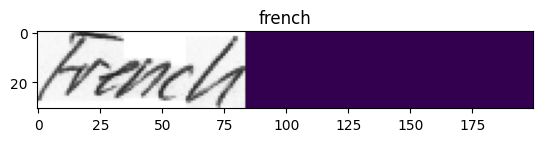

In [11]:
# Példa Generálás ( Az adatgenerátorból)
image, text = next(training_image_gen)
plt.imshow(image)
plt.title(text)
plt.show()


In [12]:
# Finomhangolás
# A keras-ocr magátol RMS-Prop -ot használ, CTC loss-al. azaz magának beállítja a learning rate-t, nem kell külön definiálni.
# A patient-et 3-ra állítottam, Hardware igények miatt.
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, restore_best_weights=True),
]
history = recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=1000
)

Epoch 1/1000


<ipython-input-12-76005257f5cc>:7: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = recognizer.training_model.fit_generator(


10851/10851 [==============================] - ETA: 0s - batch: 5425.0000 - size: 8.0000 - loss: 3.88261322 / 9646 instances have illegal characters.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


10851/10851 [==============================] - 2026s 186ms/step - batch: 5425.0000 - size: 8.0000 - loss: 3.8826 - val_loss: 3.0071
Epoch 2/1000
10851/10851 [==============================] - 2020s 186ms/step - batch: 5425.0000 - size: 8.0000 - loss: 2.6645 - val_loss: 2.5515
Epoch 3/1000
10851/10851 [==============================] - 2020s 186ms/step - batch: 5425.0000 - size: 8.0000 - loss: 2.4570 - val_loss: 2.3854
Epoch 4/1000
10851/10851 [==============================] - 2016s 186ms/step - batch: 5425.0000 - size: 8.0000 - loss: 2.3482 - val_loss: 2.5031
Epoch 5/1000
10851/10851 [==============================] - 2024s 187ms/step - batch: 5425.0000 - size: 8.0000 - loss: 2.3264 - val_loss: 2.4182
Epoch 6/1000
10851/10851 [==============================] - 2005s 185ms/step - batch: 5425.0000 - size: 8.0000 - loss: 2.3463 - val_loss: 2.3770
Epoch 7/1000
10851/10851 [==============================] - 2005s 185ms/step - batch: 5425.0000 - size: 8.0000 - loss: 2.4027 - val_loss: 2.505

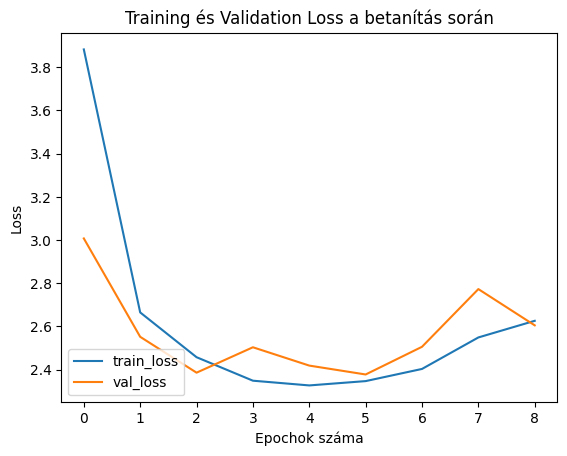

In [13]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training és Validation Loss a betanítás során")
plt.xlabel("Epochok száma")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

In [ ]:
# A google colab-ból kimentem a súlyokat.
recognizer.training_model.save('/content/drive/My Drive/my_model.h5')